# Modelli misti con Stan {#sec-stan-mixed-models}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy.stats as stats
from scipy.special import expit  # Funzione logistica
from cmdstanpy import cmdstan_path, CmdStanModel

# Configuration
seed = sum(map(ord, "stan_poisson_regression"))
rng = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Define directories
home_directory = os.path.expanduser("~")
project_directory = f"{home_directory}/_repositories/psicometria"

# Print project directory to verify
print(f"Project directory: {project_directory}")

Project directory: /Users/corradocaudek/_repositories/psicometria


## Introduzione {.unnumbered}

Il presente capitolo fornisce un riassunto della trattazione dei modelli misti fornita da @sorensen2015bayesian, a cui si rimanda per gli approfondimenti.

## Domanda della Ricerca

La questione scientifica riguarda la comprensione delle frasi nel caso di proposizioni relative di soggetto e di oggetto. Una proposizione relativa di soggetto è una frase in cui un sostantivo (ad esempio, "senatore") viene modificato da una proposizione relativa (ad esempio, "che ha interrogato il giornalista"), e il sostantivo modificato è il soggetto grammaticale della proposizione relativa. In una proposizione relativa di oggetto, il sostantivo modificato dalla proposizione relativa è l'oggetto grammaticale della proposizione (per esempio, "Il senatore che il giornalista ha interrogato si è dimesso"). In entrambi i casi, il sostantivo modificato ("senatore") è chiamato il sostantivo principale.

Un risultato comune per l'inglese è che le proposizioni relative di soggetto sono più facili da elaborare rispetto a quelle di oggetto. Le lingue naturali in generale includono proposizioni relative, e fino a poco tempo fa il vantaggio delle proposizioni di soggetto è stato considerato valido a livello cross-linguistico. Tuttavia, le proposizioni relative in cinese rappresentano un interessante controesempio a questa generalizzazione; ricerche recenti condotte da Hsiao e Gibson (2003) hanno suggerito che in cinese, le proposizioni relative di oggetto sono più facili da elaborare rispetto a quelle di soggetto in un punto specifico della frase (il sostantivo principale della proposizione relativa). Viene presentata un'analisi di un insieme di dati successivamente pubblicata [@gibson2013processing] che valuta questa affermazione.

## I Dati

La variabile dipendente dell'esperimento di @gibson2013processing era il tempo di lettura (rt) in millisecondi del sostantivo principale della proposizione relativa. Questo è stato registrato in due condizioni (proposizione relativa di soggetto e proposizione relativa di oggetto), con 37 soggetti e 15 item, presentati in un disegno standard a quadrato latino. Originariamente c'erano 16 item, ma uno è stato rimosso, risultando in 37 × 15 = 555 punti dati. Tuttavia, otto punti dati da un soggetto (id 27) erano mancanti. Di conseguenza, abbiamo un totale di 555 - 8 = 547 punti dati. La condizione (object relative / subject relative) è codificata dalla variabile `so`.

In [2]:
gibson_data = pd.read_csv("../../data/gibson_wu_2013.csv")
gibson_data.head()

,subj,item,type,pos,word,correct,rt,region,type2,so
0,1,13,obj-ext,8,男人,-,1561,headnoun,object relative,1
1,1,6,subj-ext,8,女孩,-,959,headnoun,subject relative,-1
2,1,5,obj-ext,8,轎車,-,582,headnoun,object relative,1
3,1,9,obj-ext,8,探員,-,294,headnoun,object relative,1
4,1,14,subj-ext,8,空服員,-,438,headnoun,subject relative,-1


In [3]:
gibson_data.tail()

,subj,item,type,pos,word,correct,rt,region,type2,so
542,9,15,obj-ext,8,演員,-,406,headnoun,object relative,1
543,9,16,subj-ext,8,記者,-,342,headnoun,subject relative,-1
544,9,7,obj-ext,8,狗,-,478,headnoun,object relative,1
545,9,8,subj-ext,8,業餘選手,-,510,headnoun,subject relative,-1
546,9,11,obj-ext,8,球員,-,350,headnoun,object relative,1


In [4]:
gibson_data.shape

(547, 10)

In [5]:
gibson_data["RT"] = gibson_data["rt"] / 1000

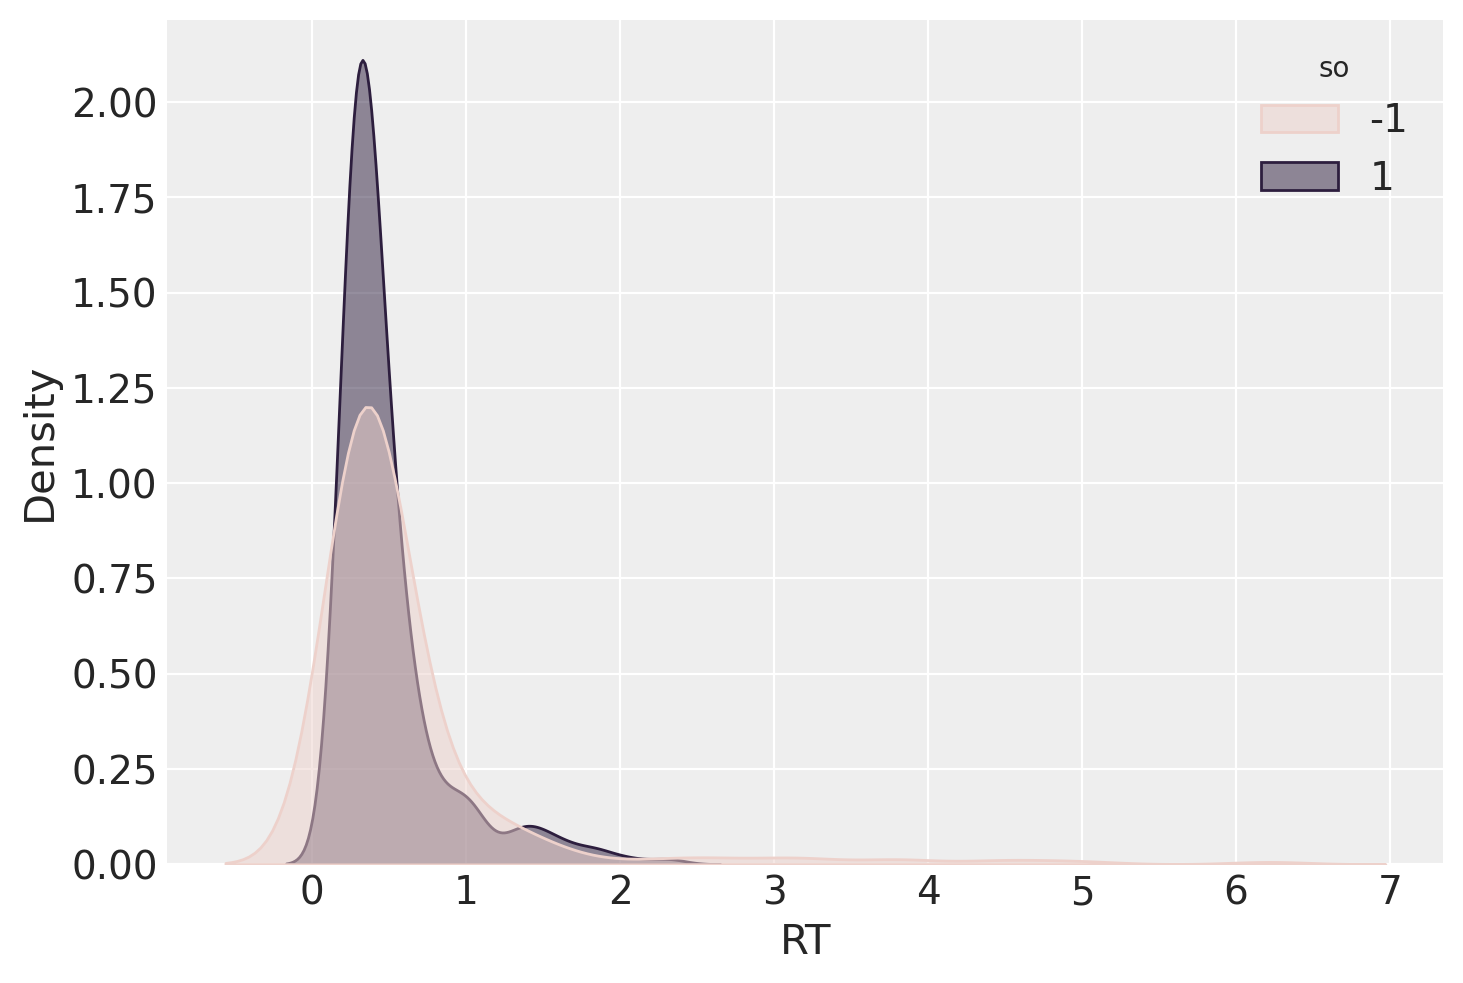

In [6]:
_ = sns.kdeplot(data=gibson_data, x='RT', hue='so', fill=True, common_norm=False, alpha=0.5)

## Modello ad effetti fissi

Iniziamo facendo l'assunzione che la variabile dipendente del tempo di lettura (rt) sul sostantivo principale sia distribuita approssimativamente in modo log-normale (Rouder, 2005). Questo presuppone che il logaritmo di rt sia distribuito approssimativamente in modo normale. Il logaritmo dei tempi di lettura, `logrt`, ha una media β0 sconosciuta. La media della distribuzione log-normale di `rt` è la somma di β0 e di uno scarto β1so il cui valore dipende dal predittore categoriale `so`, che assume il valore di -1 quando rt proviene dalla condizione di proposizione relativa di soggetto, e 1 quando rt proviene dalla condizione di proposizione relativa di oggetto. 

Il modello del logaritmo dei tempi di lettura è dunque il seguente:

$$
logrt_i = \beta_0 + \beta_1 so_i + \epsilon_i. 
$$

Questo è un modello a effetti fissi. L'indice i rappresenta la i-esima riga nel frame dati (in questo caso, i ∈ {1, . . . , 547}); il termine εi rappresenta l'errore nella i-esima riga. Con la variabile `so` codificata come indicato sopra indicato, β0 rappresenta la media di log rt, indipendentemente dal tipo di proposizione relativa. Il parametro β1 è lo scarto rispetto a β0 in modo che la media di log rt sia β0 + 1β1 quando log rt proviene dalla condizione di proposizione relativa di oggetto, e β0 - 1β1 quando log rt proviene dalla condizione di proposizione relativa di soggetto. In tali circostanze, 2β1 corrisponde alla differenza tra le medie nelle condizioni di proposizione relativa di oggetto e di soggetto. Insieme, β0 e β1 costituiscono le componenti del modello che caratterizzano l'effetto della manipolazione sperimentale (il tipo di proposizione relativa) sulla variabile dipendente rt. Questo è un modello ad effetti fissi perché i parametri β0 e β1 non variano da soggetto a soggetto o da item a item.

Compiliamo il modello e stampiamo il codice Stan:

In [8]:
stan_file = os.path.join(project_directory, "stan", "fixed_effects.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

12:32:16 - cmdstanpy - INFO - compiling stan file /Users/corradocaudek/_repositories/psicometria/stan/fixed_effects.stan to exe file /Users/corradocaudek/_repositories/psicometria/stan/fixed_effects
12:32:29 - cmdstanpy - INFO - compiled model executable: /Users/corradocaudek/_repositories/psicometria/stan/fixed_effects


data {
  int<lower=1> N;                // Number of data points
  vector[N] rt;                  // Reading time
  vector[N] so;                  // Predictor, constrained between -1 and 1
}
parameters {
  vector[2] beta;                // Intercept and slope
  real<lower=0> sigma_e;         // Error standard deviation
}
model {
  vector[N] mu;

  // Define the model for mu using vectorized operations
  mu = beta[1] + beta[2] * so;

  // Vectorized likelihood
  rt ~ lognormal(mu, sigma_e);
}



Creiamo un dizionario che include i dati nel formato atteso dal precedente codice Stan.

In [9]:
stan_data = {
    "N" : gibson_data.shape[0],
    "rt" : gibson_data["RT"],
    "so" : gibson_data["so"] 
}

Eseguiamo il campionamento.

In [10]:
fit = model.sample(data=stan_data)

12:32:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:32:52 - cmdstanpy - INFO - CmdStan done processing.
12:32:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'fixed_effects.stan', line 17, column 2 to column 30)
	Exception: lognormal_lpdf: Scale parameter is i

Esaminiamo le tracce.

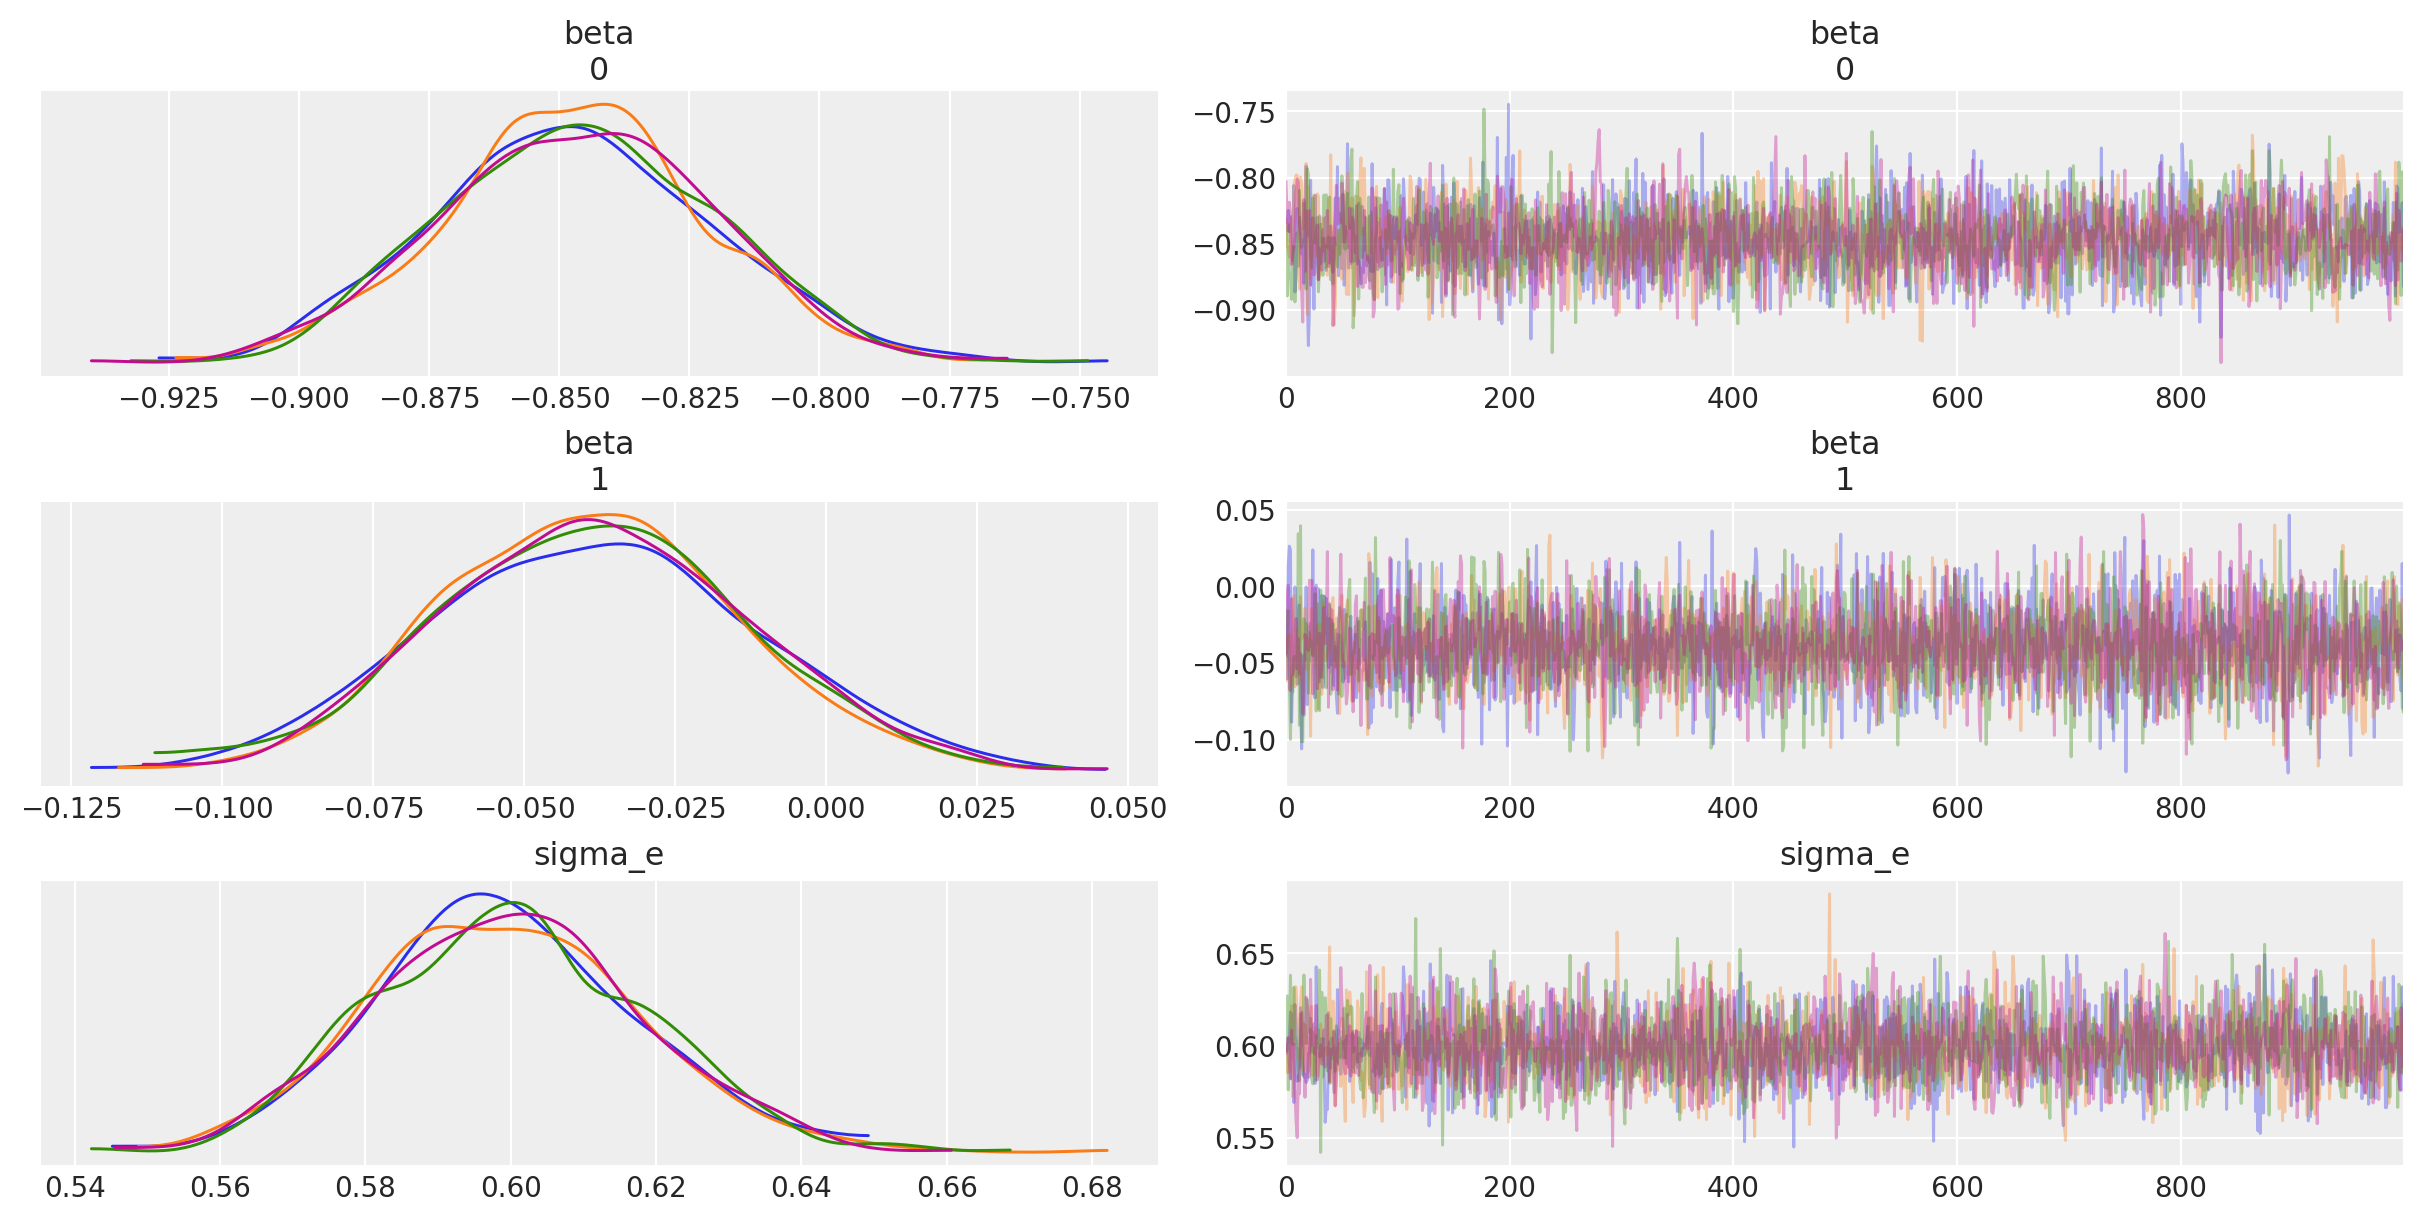

In [11]:
_ = az.plot_trace(fit, var_names=(["beta", "sigma_e"]), compact=False)

Esaminiamo le medie a posteriori e gli intervalli di credibilità dei parametri.

In [12]:
az.summary(fit, var_names=(["beta", "sigma_e"]), hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.85,0.03,-0.90,-0.80,0.0,0.0,3535.32,2985.81,1.0
beta[1],-0.04,0.03,-0.09,0.01,0.0,0.0,4901.41,3327.06,1.0
sigma_e,0.60,0.02,0.56,0.63,0.0,0.0,4436.39,2709.09,1.0


L'analisi della distribuzione di β1 indica che approssimativamente il 94% della densità di probabilità a posteriori è al di sotto dello zero, suggerendo che, in cinese, ci sia qualche evidenza che le proposizioni relative oggetto siano più facili da elaborare rispetto alle proposizioni relative soggetto, dati i dati di @gibson2013processing. Tuttavia, poiché l'intervallo di credibilità al 95% include lo zero, potremmo essere riluttanti a trarre questa conclusione, se vogliamo adottare un approccio "quasi frequentista" di test di ipotesi.

Tuttavia, è importante notare che il modello ad effetti fissi presentato qui non è comunque appropriato per i dati attuali. L'assunzione di indipendenza degli errori viene violata, perché abbiamo misure ripetute per ciascun soggetto e per ciascun item. I modelli lineari misti estendono il modello lineare per risolvere precisamente questo problema.

## Modello ad Intercette Casuali

Il modello degli effetti fissi non è adatto per i dati di @gibson2013processing poiché non tiene conto del fatto che abbiamo misurazioni multiple per ciascun soggetto e item. Come già accennato, queste misurazioni multiple portano a una violazione dell'assunzione di indipendenza degli errori. Inoltre, i coefficienti degli effetti fissi β0 e β1 rappresentano medie su tutti i soggetti e gli item, ignorando il fatto che alcuni soggetti saranno più veloci e alcuni più lenti della media; allo stesso modo, alcuni item saranno letti più rapidamente della media e altri più lentamente.

Nei modelli lineari misti, prendiamo in considerazione questa variabilità per soggetto e per item aggiungendo i termini di correzione u0j e w0k, che aggiustano β0 per il soggetto j e l'item k. Questo scompone parzialmente εi in una somma di termini u0j e w0k, che sono gli aggiustamenti dell'intercetta β0 per il soggetto j e l'item k associato a rt_i. Se il soggetto j è più lento della media di tutti i soggetti, uj sarà un numero positivo, e se l'item k viene letto più velocemente della durata media di tutti gli item, allora wk sarà un numero negativo. Ogni soggetto j ha il proprio aggiustamento u0j, e ogni item ha il proprio aggiustamento w0k. Questi aggiustamenti u0j e w0k sono chiamati *intercette casuali* (*random intercepts*) da Pinheiro e Bates (2000) e *intercette variabili* (*varying intercepts*) da Gelman e Hill (2007), e aggiustando β0 con questi termini miglioriamo la nostra capacità di tener conto della variabilità per i soggetti e per gli item.

Il modello statistico ad intercette casuali assume che questi aggiustamenti sono distribuiti normalmente intorno allo zero con deviazione standard sconosciuta: 

$$
u_0 \sim N(0, \sigma_u), 
$$

$$
w_0 ∼ N(0, \sigma_w). 
$$

Avendo specificato il modello in questo modo, ci sono tre fonti di varianza: la deviazione standard degli errori σe, la deviazione standard delle intercette casuali per i soggetti, σu, e la deviazione standard delle intercette casuali per gli item, σw. Ci riferiamo a questi valori come alle componenti della varianza.

Esprimiamo ora il logaritmo del tempo di lettura, prodotto dai soggetti j ∈ {1, . . . , 37} che leggono gli item k ∈ {1,..., 15}, nelle condizioni i ∈ {1, 2} (1 si riferisce alle proposizioni soggetto, 2 alle proposizioni oggetto), come la seguente somma. 

$$
\log rt_{ijk} = \beta_0 + \beta_{1i} + u_{0j} + w_{0k} + \varepsilon_{ijk}.
$$

Notiamo che stiamo utilizzando un modo leggermente diverso per descrivere il modello, rispetto al modello degli effetti fissi. Stiamo utilizzando indici per soggetto, item e condizione per identificare ciascuna riga del data frame. Inoltre, anziché scrivere $\beta_1 so_i$, indicizziamo direttamente β1 in funzione della condizione i (essendo `so` $\in \{-1, 1\}$). 

Questo è un modello è un modello ad effetti misti, e più specificamente un modello ad intercette casuali. Il coefficiente $\beta_{1i}$ è quello di maggior interesse; avrà un valore medio −β1 per le proposizioni soggetto e β1 per le proposizioni oggetto a causa della codifica del contrasto. Quindi, se la nostra media a posteriori per β1 è negativa, ciò suggerirebbe che le proposizioni oggetto vengono lette più velocemente delle proposizioni soggetto.

In [13]:
stan_file = os.path.join(project_directory, "stan", "random_intercepts.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

12:33:49 - cmdstanpy - INFO - compiling stan file /Users/corradocaudek/_repositories/psicometria/stan/random_intercepts.stan to exe file /Users/corradocaudek/_repositories/psicometria/stan/random_intercepts
12:34:01 - cmdstanpy - INFO - compiled model executable: /Users/corradocaudek/_repositories/psicometria/stan/random_intercepts


data {
  int<lower=0> N;                  // Number of data points
  vector[N] rt;                    // Reading time
  vector[N] so;                    // Predictor, constrained between -1 and 1
  int<lower=0> J;                  // Number of subjects
  int<lower=0> K;                  // Number of items
  array[N] int<lower=0, upper=J> subj;
  array[N] int<lower=0, upper=K> item;
}
parameters {
  vector[2] beta;                  // Fixed intercept and slope
  vector[J] u;                     // Subject intercepts
  vector[K] w;                     // Item intercepts
  real<lower=0> sigma_e;           // Error standard deviation
  real<lower=0> sigma_u;           // Subject standard deviation
  real<lower=0> sigma_w;           // Item standard deviation
}
model {
  vector[N] mu;

  // Priors
  beta ~ normal(0, 5);             // Assuming a weakly informative prior for beta
  u ~ normal(0, sigma_u);
  w ~ normal(0, sigma_w);
  sigma_e ~ exponential(1);
  sigma_u ~ exponential(1);
  sig

In [14]:
stan_data = {
    'subj': pd.factorize(gibson_data['subj'])[0] + 1,
    'item': pd.factorize(gibson_data['item'])[0] + 1,
    'rt': gibson_data['RT'].values,
    'so': gibson_data['so'].values,
    'N': len(gibson_data),
    'J': gibson_data['subj'].nunique(),
    'K': gibson_data['item'].nunique()
}

In [15]:
fit = model.sample(data=stan_data)

12:34:12 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:34:13 - cmdstanpy - INFO - CmdStan done processing.
12:34:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in 'random_intercepts.stan', line 31, column 2 to column 30)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'random_intercepts.stan', line 24, column 2 to column 25)
Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in 'random_intercepts.stan', line 31, column 2 to column 30)
Consider re-running with show_console=True if the above output is unclear!


In [16]:
az.summary(fit, var_names=(["beta", "sigma_e", "sigma_u", "sigma_w"]), hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.85,0.07,-0.97,-0.70,0.0,0.0,1101.73,1576.57,1.0
beta[1],-0.04,0.02,-0.08,0.01,0.0,0.0,9851.81,3141.84,1.0
sigma_e,0.52,0.02,0.49,0.55,0.0,0.0,7247.72,2689.88,1.0
sigma_u,0.25,0.04,0.17,0.33,0.0,0.0,3714.95,2902.11,1.0
sigma_w,0.20,0.05,0.11,0.30,0.0,0.0,3978.74,2983.07,1.0


Si noti che rispetto al Modello ad effetti fissi, la stima di σe è più piccola; questo perché ora vengono stimate due componenti di varianza aggiuntive. Si noti inoltre che l'intervallo di credibilità al 95% per la stima di β1 include lo zero; quindi, c'è ancora qualche evidenza che le proposizioni oggetto siano più facili delle proposizioni soggetto, ma non possiamo escludere la possibilità che non ci sia una differenza credibile nei tempi di lettura tra i due tipi di proposizioni relative.

Il presente modello con intercette casuali assume che l'effetto della variabile `so` sia lo stesso per ciascun soggetto.Ma questo non è necessariamente vero. Per consentire al modello di tenere conto che l'effetto della variabile `so` possa variare tra i soggetti, dobbiamo estendere il presente modello e trasformarlo in un modello che include sia intercette sia pendenze casuali.

## Random Intercepts, Random Slopes Model

Per esprimere la struttura descritta sopra nel modello lineare misto, dobbiamo specificare le pendenze casuali. Il primo cambiamento consiste nel permettere che la dimensione dell'effetto per `so` varii per soggetto e per item. Consentiamo che la dimensione dell'effetto vari per soggetto e per item includendo nel modello pendenze variabili per soggetto e per item, che costituiscono degli scarti rispetto alla pendenza fissa β1, allo stesso modo in cui le intercette variabili per soggetto e per item aggiustano l'intercetta fissa β0. Questo aggiustamento della pendenza per soggetto e per item è espresso aggiustando β1 tramite due termini u1j e w1k. Questi termini rappresentano le pendenze casuali. Aggiungendo al modello tali termini aggiuntivi possiamo rendere conto del fatto che l'effetto del tipo di proposizione relativa varia per soggetto j e per item k. 

Esprimiamo il logaritmo del tempo di lettura, prodotto dal soggetto j che legge l'item k, come la seguente somma. 

$$
\text{log } rt_{ijk} = \beta_0 + u_{0j} + w_{0k} + \beta_{1i} + u_{1ij} + w_{1ik} + \epsilon_{ijk},
$$

dove il pedice $i$ indica le condizioni. Questo è un modello di intercette variabili e pendenze variabili.

Il modello è specificato in linguaggio Stan come indicato nel file `random_slopes.stan`.

In [18]:
stan_file = os.path.join(project_directory, "stan", "random_slopes.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

12:35:00 - cmdstanpy - INFO - compiling stan file /Users/corradocaudek/_repositories/psicometria/stan/random_slopes.stan to exe file /Users/corradocaudek/_repositories/psicometria/stan/random_slopes
12:35:11 - cmdstanpy - INFO - compiled model executable: /Users/corradocaudek/_repositories/psicometria/stan/random_slopes


data {
  int<lower=0> N;                  // Number of data points
  vector[N] rt;                    // Reading time
  vector[N] so;                    // Predictor, constrained between -1 and 1
  int<lower=0> J;                  // Number of subjects
  int<lower=0> K;                  // Number of items
  array[N] int<lower=0, upper=J> subj;
  array[N] int<lower=0, upper=K> item;
}
parameters {
  vector[2] beta;                  // Fixed intercept and slope
  real<lower=0> sigma_e;           // Error standard deviation
  matrix[2,J] u;                   // Subject intercepts and slopes
  vector<lower=0>[2] sigma_u;      // Subject standard deviations
  matrix[2,K] w;                   // Item intercepts and slopes
  vector<lower=0>[2] sigma_w;      // Item standard deviations
}
model {
  // Priors
  for (j in 1:J) {
    u[1,j] ~ normal(0, sigma_u[1]); // Prior for subject intercepts
    u[2,j] ~ normal(0, sigma_u[2]); // Prior for subject slopes
  }
  
  for (k in 1:K) {
    w[1,k] ~

In [19]:
fit = model.sample(
    data=stan_data,
    iter_sampling = 2000,
    iter_warmup = 1000,
)

12:35:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:35:26 - cmdstanpy - INFO - CmdStan done processing.
12:35:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_slopes.stan', line 34, column 4 to column 35)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_slopes.stan', line 34, column 4 to column 35)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_slopes.stan', line 34, column 4 to column 35)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_slopes.stan', line 34, column 4 to column 35)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'random_slopes.stan', line 21, column 4 to column 35)
	Exception: lognormal_lpdf: Scale parameter is inf, but must be positive finite! (in 'random_slopes.stan', line 34, column 4 to column 35)
Exception: lognormal_lpdf: Scale parameter is inf, but mus

In [20]:
az.summary(fit, var_names=(["beta", "sigma_e", "sigma_u", "sigma_w"]), hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.85,0.07,-0.98,-0.71,0.00,0.0,706.84,302.85,1.01
beta[1],-0.04,0.03,-0.09,0.02,0.00,0.0,1982.52,4756.68,1.00
sigma_e,0.52,0.02,0.48,0.55,0.00,0.0,2288.99,5672.93,1.00
sigma_u[0],0.25,0.04,0.18,0.34,0.00,0.0,712.02,275.18,1.01
sigma_u[1],0.06,0.04,0.01,0.12,0.01,0.0,39.10,29.54,1.09
sigma_w[0],0.20,0.05,0.11,0.30,0.00,0.0,4099.46,5332.27,1.00
sigma_w[1],0.04,0.03,0.00,0.11,0.00,0.0,114.76,68.32,1.03


Anche in questo caso, @sorensen2015bayesian commentano che l'intervallo di credibilità al 95% per $\beta_1$ include lo zero. 

## Modello a Effetti Misti con Pendenze e Intercepce Casuali Correlate

@sorensen2015bayesian, nell'approfondire l'analisi dei dati presentati da @gibson2013processing, propongono un avanzamento metodologico nel modello preso in considerazione, introducendo un modello a effetti misti che incorpora intercette e pendenze casuali correlate. La logica dietro questo approccio consiste nell'esaminare la possibilità che vi sia una relazione tra la velocità di lettura dei soggetti (espressa attraverso intercette casuali) e la loro reazione alle diverse tipologie di proposizioni (oggetto vs. soggetto), ipotizzando che soggetti con una velocità di lettura superiore alla media possano esperire un rallentamento maggiore nel leggere proposizioni oggetto rispetto alle proposizioni soggetto, e viceversa. Questa ipotesi suggerisce l'esistenza di correlazioni tra le intercette casuali (che rappresentano variazioni individuali nella velocità di base di lettura) e le pendenze casuali (che rappresentano la variazione nella risposta al tipo di proposizione).

Per integrare questa struttura nel modello lineare misto (LMM), è essenziale modellare la correlazione tra intercette casuali e pendenze casuali. La formula del modello, la quale rimane inalterata rispetto alla versione precedente, è rappresentata come segue:

$$
\text{log } rt_{ijk} = \beta_0 + u_{0j} + w_{0k} + \beta_1 + u_{1ij} + w_{1ik} + \epsilon_{ijk}.
$$

L'introduzione di correlazioni tra intercette e pendenze casuali trasforma il modello in un approccio di intercette e pendenze correlate, richiedendo la definizione di una matrice di varianza-covarianza per gli effetti casuali. Questo implica la necessità di stabilire una relazione di covarianza tra le intercette casuali (per soggetto e per item) e le pendenze casuali (per soggetto e per item), suggerendo che le pendenze per soggetto (u1) potrebbero correlare con le intercette per soggetto (u0), così come le pendenze per item (w1) potrebbero correlare con le intercette per item (w0). Questo approccio offre una visione più dettagliata e accurata della dinamica tra velocità di lettura individuale e reazione alle differenti strutture sintattiche, arricchendo significativamente l'analisi statistica dei dati comportamentali.

Nel contesto di questo insegnamento, non approfondiremo la formulazione del modello Stan che include la correlazione tra pendenze e intercette, data la sua complessità tecnica. Tuttavia, è importante sottolineare che è possibile ottenere risultati analoghi con un approccio più accessibile utilizzando il pacchetto Bambi per Python. Questo strumento consente di specificare modelli statistici in maniera intuitiva e diretta. Per esempio, per incorporare la correlazione tra pendenze e intercette nel nostro modello, possiamo utilizzare la seguente sintassi con Bambi:

```python
model = bmb.Model("rt ~ so + (so | subject) + (so | item)", data)
```

Questa espressione crea un modello in cui `rt` (il tempo di risposta) è modellato come una funzione del tipo di proposizione `so`, con pendenze e intercette casuali correlate sia per `subject` che per `item`. L'uso di `(so | subject)` e `(so | item)` permette di modellare specificamente le variazioni nelle risposte attribuibili a differenze individuali tra i soggetti e caratteristiche uniche degli item, rispettivamente. Questa sintassi semplifica notevolmente l'implementazione di modelli complessi, rendendo l'analisi accessibile anche a chi possiede una conoscenza di base della statistica bayesiana e della modellazione statistica.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanp

Last updated: Fri Jul 26 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

cmdstanp: not installed

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.2
matplotlib: 3.9.1
scipy     : 1.14.0
arviz     : 0.18.0
seaborn   : 0.13.2
numpy     : 1.26.4

Watermark: 2.4.3

